In [32]:
%matplotlib inline

# Importaciones de Python estándar
import os
from subprocess import call

# Importaciones de NumPy
import numpy as np

# Importaciones de Matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Importaciones de Seaborn
import seaborn as sns 

# Importaciones de SciPy
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Importaciones de IPython
from IPython.display import display, clear_output

# Importaciones de ipywidgets
from ipywidgets import interact, widgets, FloatSlider, FloatText, fixed
from ipywidgets import widgets as wgt


import xgboost as xgb

# Actualización de los parámetros de Matplotlib
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
                                    
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el colormap personalizado
rgb = {'red': ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 1.0, 1.0)),

        'green': ((0.0, 0.0, 0.0),
                    (0.5, 1.0, 1.0),
                    (1.0, 0.0, 0.0)),

        'blue': ((0.0, 1.0, 1.0),
                (0.5, 1.0, 1.0),
                (1.0, 0.0, 0.0))
        }

# Definir el colormap
rgb = LinearSegmentedColormap('RedGreenBlue', rgb)

In [4]:
import numpy as np
# Specify the file path
file_path = 'inputs/preassures.txt'

# Load the file
data = np.loadtxt(file_path)

x = data[:, 0]
y = data[:, 1]
t = data[:, 2]
u = data[:, 3]


In [5]:
np.shape(u), np.shape(x), np.shape(y), np.shape(t)  # Asegúrate de que las dimensiones sean correctas

((2520000,), (2520000,), (2520000,), (2520000,))

In [6]:
unique_t, counts = np.unique(t, return_counts=True)
num_unique_t = len(unique_t)
num_unique_t

28

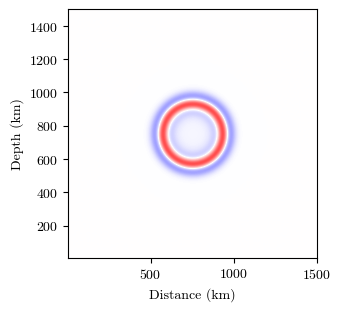

In [7]:
unique_t, counts = np.unique(t, return_counts=True)
num_unique_t = len(unique_t)
# Asegúrate de que x, y y u tengan la misma longitud
assert len(x) == len(y) == len(u)
x_splits = np.array_split(x, num_unique_t)
y_splits = np.array_split(y, num_unique_t)
u_splits = np.array_split(u, num_unique_t)
x_test = x_splits[10]
y_test = y_splits[10]
u_test = u_splits[10]
u_test = u_test / np.max(np.abs(u_test))

wavefields = u_test.reshape((len(np.unique(y_test)), len(np.unique(x_test))))

# Definir los límites de los ejes
x_min, x_max = np.min(x_test), np.max(x_test)
y_min, y_max = np.min(y_test), np.max(y_test)
wavefields_min, wavefields_max = np.min(wavefields), np.max(wavefields)

# Crear la figura y el subplot
plt.figure(figsize=(4, 3))
plt.xlabel('Distance (km)', fontsize=10)
plt.ylabel('Depth (km)', fontsize=10)

# Mostrar el subplot
plt.imshow(wavefields, extent=[x_min, x_max, y_min, y_max], aspect=1, cmap=rgb, alpha=0.7, vmin=-wavefields_max, vmax=wavefields_max)

# Mostrar la figura
plt.show()

In [13]:
np.shape(x_test)

(90000,)

In [58]:
# Create a 2D grid of x and y values
unique_x, counts = np.unique(x_test, return_counts=True)
unique_y, counts = np.unique(y_test, return_counts=True)

X, Y = np.meshgrid(unique_x, unique_y)
U=wavefields

In [24]:
np.shape(U), np.shape(X), np.shape(Y)

((300, 300), (300, 300), (300, 300))

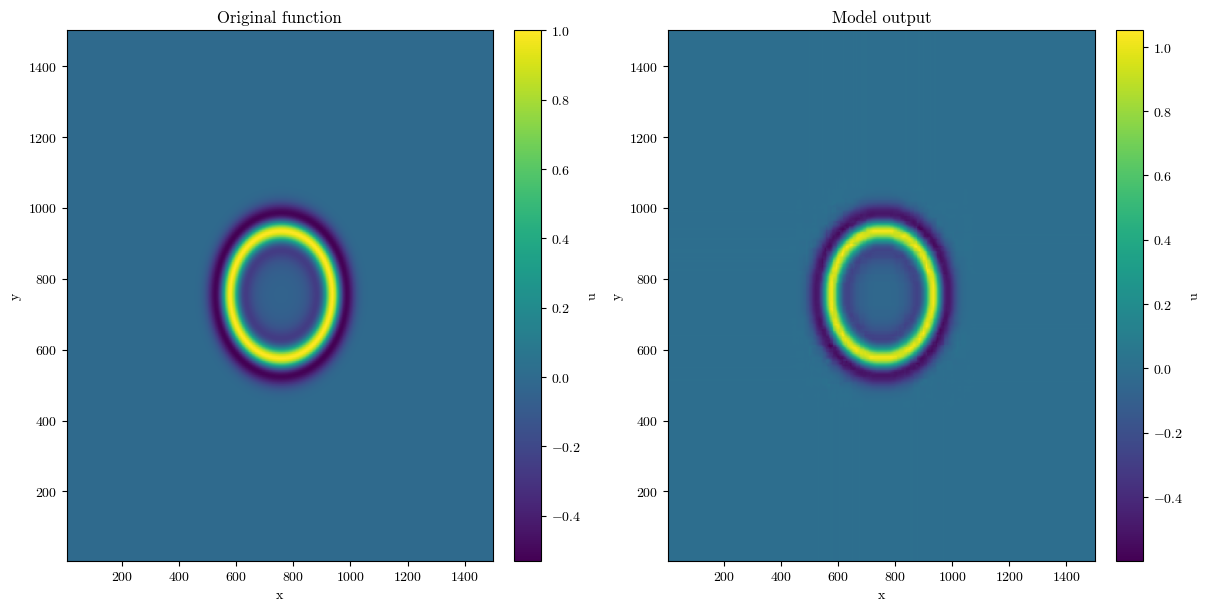

In [46]:
# Prepare the inputs and targets
inputs = np.stack((X, Y), axis=-1).reshape(-1, 2)
targets = U.reshape(-1, 1)

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 500)

# Train the model
model.fit(inputs, targets)

# Generate a grid of (x, y) values
xv, yv = np.meshgrid(unique_x, unique_y)
grid = np.stack((xv, yv), axis=-1).reshape(-1, 2)

# Predict the output for the grid
output_flat = model.predict(grid)

# Reshape the output to match the original grid shape
output = output_flat.reshape(xv.shape)

# Plot the original function
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(U, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Original function')
plt.xlabel('x')
plt.ylabel('y')

# Plot the model's output
plt.subplot(1, 2, 2)
plt.imshow(output, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Model output')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

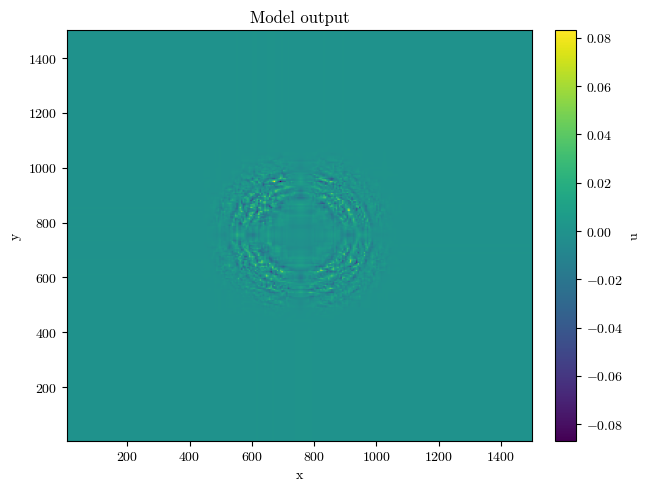

In [40]:
plt.imshow(U-output, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Model output')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [67]:
# Convertir los datos a tensores de PyTorch
inputs = torch.FloatTensor(np.stack((X, Y), axis=-1).reshape(-1, 2))
targets = torch.FloatTensor(U.reshape(-1, 1))

# Convert inputs and targets to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
    
model = FCN(1,1,32,3)
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        

/tmp/ipykernel_15536/2082746667.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_15536/2082746667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


Epoch [50/500], Loss: 2.1003
Epoch [100/500], Loss: 0.2247
Epoch [150/500], Loss: 0.0946
Epoch [200/500], Loss: 0.0522
Epoch [250/500], Loss: 0.0355
Epoch [300/500], Loss: 0.0282
Epoch [350/500], Loss: 0.0247
Epoch [400/500], Loss: 0.0230
Epoch [450/500], Loss: 0.0221
Epoch [500/500], Loss: 0.0217


MemoryError: Unable to allocate 46.2 TiB for an array with shape (2520000, 2520000) and data type float64

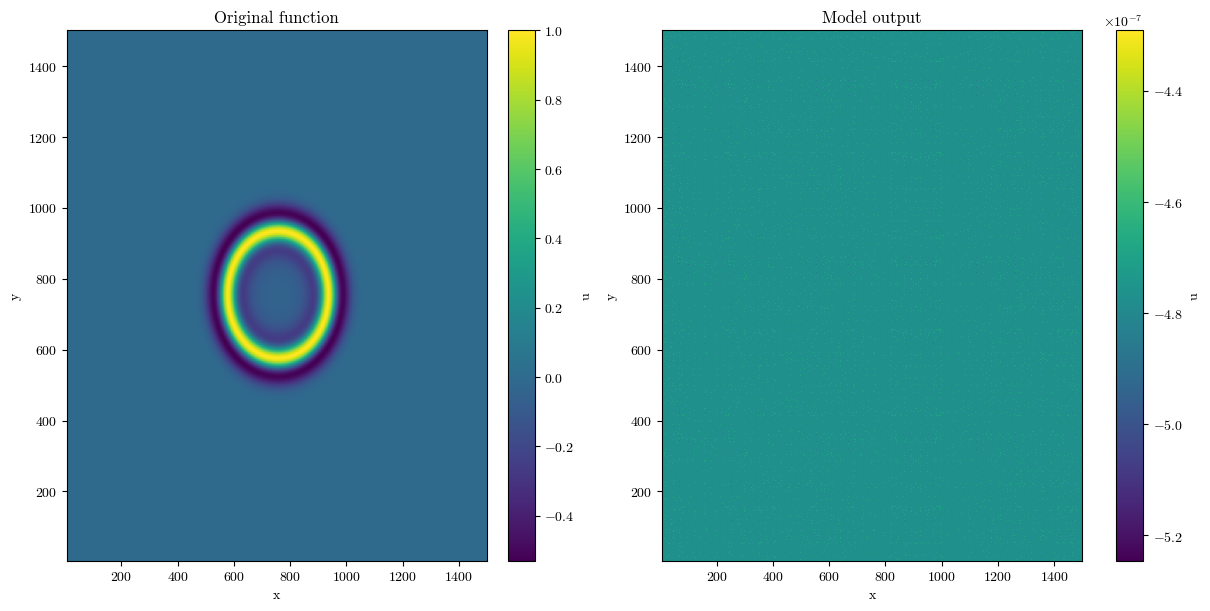

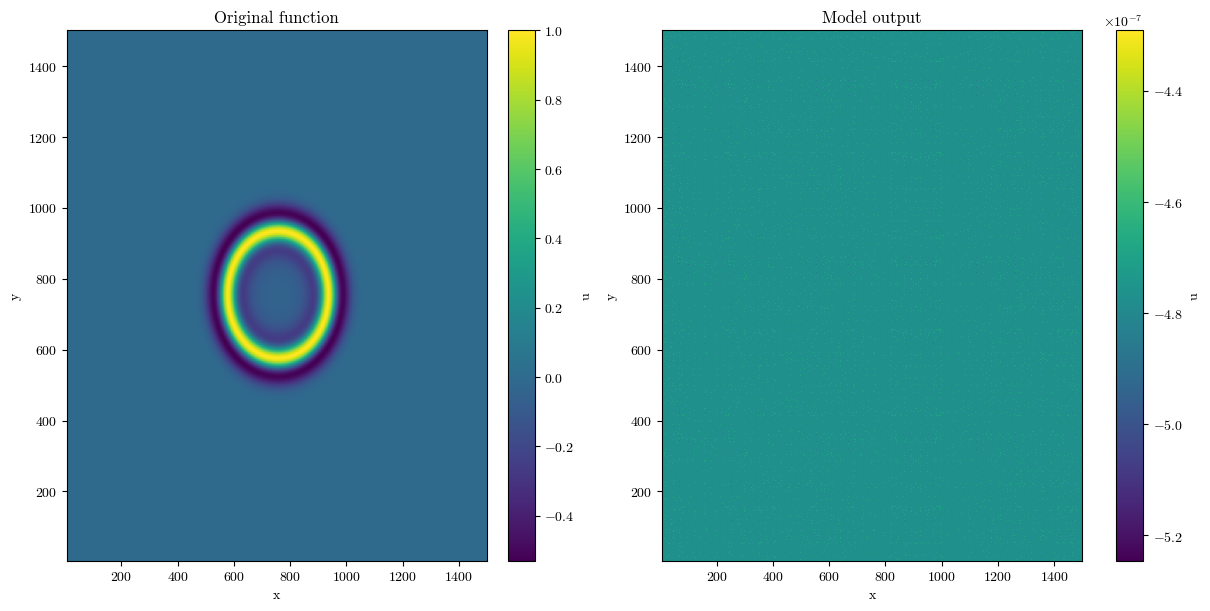

In [70]:

# Plot the original function
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(U, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Original function')
plt.xlabel('x')
plt.ylabel('y')

# Plot the model's output
plt.subplot(1, 2, 2)
plt.imshow(output, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Model output')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [63]:
import tensorflow as tf
# Create a 2D grid of x and y values
unique_x, counts = np.unique(x_test, return_counts=True)
unique_y, counts = np.unique(y_test, return_counts=True)

X, Y = np.meshgrid(unique_x, unique_y)
U=wavefields

In [64]:

# Prepare the inputs and targets
inputs = np.stack((X, Y), axis=-1).reshape(-1, 2)
targets = U.reshape(-1, 1)

# Define the neural network model
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = tf.keras.layers.Dense(10, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Initialize the network
model = Net()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='mean_squared_error')

# Define a callback to print progress
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {logs["loss"]}')

# Train the network
history = model.fit(inputs, targets, epochs=50, verbose=0, callbacks=[PrintProgress()])



Epoch 0, Loss: nan


KeyboardInterrupt: 

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step


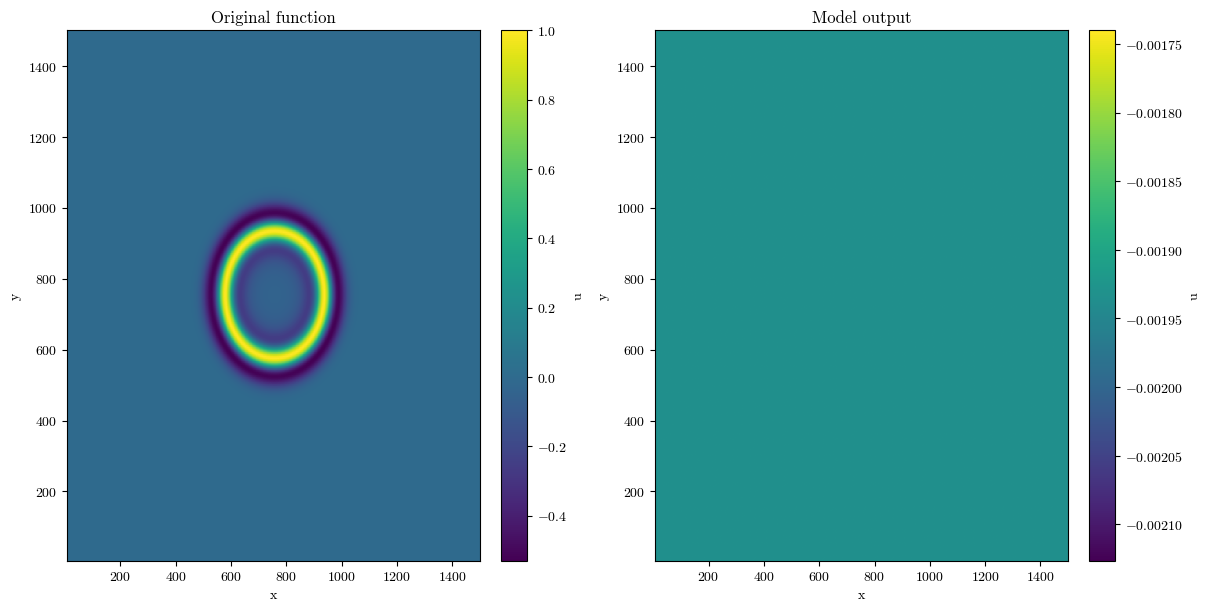

In [55]:
# Pass the grid through the model
output = model.predict(grid.reshape(-1, 2)).reshape(xv.shape)

# Plot the original function
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(U, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Original function')
plt.xlabel('x')
plt.ylabel('y')

# Plot the model's output
plt.subplot(1, 2, 2)
plt.imshow(output, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
plt.colorbar(label='u')
plt.title('Model output')
plt.xlabel('x')
plt.ylabel('y')

plt.show()